Installing dependencies

In [19]:
! pip install -q datasets rouge-score transformers accelerate sentencepiece nltk

Importing libraries

In [43]:
import os, time, random, math
import numpy as np
import pandas as pd
from tqdm import tqdm
import torch
from datasets import load_dataset
from rouge_score import rouge_scorer

SEED = 42
random.seed(SEED); np.random.seed(SEED); torch.manual_seed(SEED)

Choosen Dataset

In [44]:
DATASETS = {
    "xsum": {"split": "test", "n_samples": 150},
    "cnn_dailymail": {"split": "test", "n_samples": 150}
}

Choosing abstractive models per dataset

In [ ]:
ABSTRACTIVE_MODELS = {
    "xsum": "facebook/bart-large-xsum",   
    "cnn_dailymail": "facebook/bart-large-cnn",
}

MAX_INPUT_CHARS = {
    "xsum": 3000,
    "cnn_dailymail": 4500
}

Generating parameters for each dataset

In [46]:
GEN_KW = {
    "xsum":   {"max_new_tokens": 64, "num_beams": 2, "temperature": 1.0, "top_p": 1.0},
    "cnn_dailymail":{"max_new_tokens": 128, "num_beams": 2, "temperature": 1.0, "top_p": 1.0},
}

In [ ]:
DEVICE = "cuda" if torch.cuda.is_available() else (
    "mps" if hasattr(torch.backends, "mps") and torch.backends.mps.is_available() else "cpu"
)
USE_HALF = (DEVICE == "cuda")   
print("Using device:", DEVICE)


Using device: cpu


Loading the dataset

In [ ]:
from datasets import load_dataset
import pandas as pd

def load_and_normalize(name: str, split: str):
    if name == "xsum":
        ds = load_dataset("xsum", split=split, trust_remote_code=True)
        df = pd.DataFrame({"text": ds["document"], "summary": ds["summary"]})
        return df.dropna().reset_index(drop=True)

    elif name == "cnn_dailymail":
        ds = load_dataset("cnn_dailymail", "3.0.0", split=split, trust_remote_code=True)
        df = pd.DataFrame({"text": ds["article"], "summary": ds["highlights"]})
        return df.dropna().reset_index(drop=True)

    else:
        raise ValueError("Unsupported dataset: " + name)



In [50]:
tmp = load_dataset("cnn_dailymail", "3.0.0", split="test[:3]", trust_remote_code=True)
print(tmp.column_names)
print(tmp[0]["article"][:200], "\n---\n", tmp[0]["highlights"])

c:\Users\hemam\AppData\Local\Programs\Python\Python312\Lib\site-packages\huggingface_hub\file_download.py:139: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\hemam\.cache\huggingface\hub\datasets--cnn_dailymail. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)
Generating test split: 100%|██████████| 11490/11490 [00:00<00:00, 112138.29 examples/s]

['article', 'highlights', 'id']
(CNN)The Palestinian Authority officially became the 123rd member of the International Criminal Court on Wednesday, a step that gives the court jurisdiction over alleged crimes in Palestinian territor 
---
 Membership gives the ICC jurisdiction over alleged crimes committed in Palestinian territories since last June .
Israel and the United States opposed the move, which could open the door to war crimes investigations against Israelis .


Extractive try and expect block

In [51]:
try:
    _ = extractive_summarization  # type: ignore
    def run_extractive(text, target_len_chars=300):
        return extractive_summarization(text, max_length=target_len_chars) 
except NameError:
    # Fallback: simple Lead-3 baseline
    import nltk
    nltk.download("punkt", quiet=True)
    from nltk.tokenize import sent_tokenize
    def run_extractive(text, k=3):
        try:
            return " ".join(sent_tokenize(text)[:k])
        except Exception:
            return text

Abstractive model

In [ ]:
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM
import torch

_abs_cache = {}
_tok_cache = {}

def get_abs_model_and_tok(dataset_name: str):
    key = ABSTRACTIVE_MODELS[dataset_name]
    if key not in _abs_cache:
        tok = AutoTokenizer.from_pretrained(key)
        mdl = AutoModelForSeq2SeqLM.from_pretrained(key)  
        if USE_HALF and DEVICE == "cuda":
            mdl = mdl.half()
        mdl.to(DEVICE)  
        _abs_cache[key] = mdl
        _tok_cache[key] = tok
    return _abs_cache[key], _tok_cache[key]

@torch.no_grad()
def generate_abs(dataset_name: str, text: str):
    mdl, tok = get_abs_model_and_tok(dataset_name)
    params = GEN_KW[dataset_name]
    inputs = tok(text, return_tensors="pt", truncation=True, padding=True, max_length=1024)
    inputs = {k: v.to(DEVICE) for k, v in inputs.items()}
    out = mdl.generate(
        **inputs,
        max_new_tokens=params["max_new_tokens"],
        num_beams=params["num_beams"],
        do_sample=(params["temperature"] != 1.0 or params["top_p"] < 1.0),
        temperature=params["temperature"],
        top_p=params["top_p"]
    )
    return tok.decode(out[0], skip_special_tokens=True)



In [54]:
print("Model (cnn):", ABSTRACTIVE_MODELS["cnn_dailymail"])
print("Device:", DEVICE)
print("Test gen:", generate_abs("cnn_dailymail", "The mayor announced new traffic regulations to ease congestion in the city center."))



Model (cnn): facebook/bart-large-cnn
Device: cpu


c:\Users\hemam\AppData\Local\Programs\Python\Python312\Lib\site-packages\huggingface_hub\file_download.py:139: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\hemam\.cache\huggingface\hub\models--facebook--bart-large-cnn. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)


Test gen: The mayor announced new traffic regulations to ease congestion in the city center. The new traffic rules are expected to be in place by the end of the year. The regulations are designed to ease traffic congestion in and around the city centre. They include a new traffic light system and new traffic calming measures.


Rouge Evaluation

In [56]:
scorer = rouge_scorer.RougeScorer(["rouge1","rouge2","rougeLsum"], use_stemmer=True)

def rouge_for_pair(ref, pred):
    s = scorer.score(ref, pred)
    return s["rouge1"].fmeasure, s["rouge2"].fmeasure, s["rougeLsum"].fmeasure

def eval_dataset(name:str, df:pd.DataFrame):
    r = {"abs_r1":[], "abs_r2":[], "abs_rl":[], "ext_r1":[], "ext_r2":[], "ext_rl":[]}
    abs_list, ext_list = [], []
    for _, row in tqdm(df.iterrows(), total=len(df), desc=f"EVAL {name}"):
        text = row["text_trunc"]; ref = row["summary"]
        a = generate_abs(name, text); e = run_extractive(text)
        abs_list.append(a); ext_list.append(e)
        r1,r2,rl = rouge_for_pair(ref, a); r["abs_r1"].append(r1); r["abs_r2"].append(r2); r["abs_rl"].append(rl)
        r1,r2,rl = rouge_for_pair(ref, e); r["ext_r1"].append(r1); r["ext_r2"].append(r2); r["ext_rl"].append(rl)
    table = pd.DataFrame({
        "metric": ["ROUGE-1","ROUGE-2","ROUGE-Lsum"],
        "Abstractive": [np.mean(r["abs_r1"]), np.mean(r["abs_r2"]), np.mean(r["abs_rl"])],
        "Extractive": [np.mean(r["ext_r1"]), np.mean(r["ext_r2"]), np.mean(r["ext_rl"])]
    })
    return table, abs_list, ext_list

Running both the datasets

In [ ]:
import math
from tqdm import tqdm

all_results = {}
os.makedirs("results", exist_ok=True)

SAVE_ALL_SAMPLES = False

if DEVICE == "cuda":
    BATCH_SIZE = 8
elif DEVICE == "mps":
    BATCH_SIZE = 4
else:
    BATCH_SIZE = 2  # CPU

def generate_abs_batched(dataset_name: str, texts: list) -> list:
    """Generate abstractive summaries in batches for speed."""
    mdl, tok = get_abs_model_and_tok(dataset_name)
    mdl.eval()
    params = GEN_KW[dataset_name]
    outputs = []

    for i in tqdm(range(0, len(texts), BATCH_SIZE), desc=f"ABS GEN ({dataset_name})"):
        batch = texts[i:i + BATCH_SIZE]
        try:
            enc = tok(
                batch,
                return_tensors="pt",
                truncation=True,
                padding=True,
                max_length=1024
            )
            enc = {k: v.to(DEVICE) for k, v in enc.items()}
            with torch.no_grad():
                gen = mdl.generate(
                    **enc,
                    max_new_tokens=params["max_new_tokens"],
                    num_beams=params["num_beams"],
                    do_sample=(params["temperature"] != 1.0 or params["top_p"] < 1.0),
                    temperature=params["temperature"],
                    top_p=params["top_p"]
                )
            batch_out = tok.batch_decode(gen, skip_special_tokens=True)
        except Exception as e:
         
            batch_out = [""] * len(batch)
        outputs.extend(batch_out)
    return outputs

def eval_with_rouge(name: str, df_in: pd.DataFrame):
    """Run extractive + abstractive, compute ROUGE table, and return lists."""
  
    abs_list = generate_abs_batched(name, df_in["text_trunc"].tolist())

    ext_list = []
    for t in tqdm(df_in["text_trunc"].tolist(), desc=f"EXT GEN ({name})"):
        try:
            ext_list.append(run_extractive(t))
        except Exception:
            ext_list.append("")

   
    abs_r1, abs_r2, abs_rl = [], [], []
    ext_r1, ext_r2, ext_rl = [], [], []
    for ref, a, e in tqdm(zip(df_in["summary"], abs_list, ext_list), total=len(df_in), desc=f"ROUGE ({name})"):
        r1, r2, rl = rouge_for_pair(ref, a); abs_r1.append(r1); abs_r2.append(r2); abs_rl.append(rl)
        r1, r2, rl = rouge_for_pair(ref, e); ext_r1.append(r1); ext_r2.append(r2); ext_rl.append(rl)

    table = pd.DataFrame({
        "metric": ["ROUGE-1", "ROUGE-2", "ROUGE-Lsum"],
        "Abstractive": [float(np.mean(abs_r1)), float(np.mean(abs_r2)), float(np.mean(abs_rl))],
        "Extractive": [float(np.mean(ext_r1)), float(np.mean(ext_r2)), float(np.mean(ext_rl))]
    })
    return table, abs_list, ext_list


for name, cfg in DATASETS.items():
   
    df = load_and_normalize(name, cfg["split"])
    n = min(cfg["n_samples"], len(df))
    df = df.sample(n, random_state=SEED).reset_index(drop=True)
    df["text_trunc"] = df["text"].apply(lambda t: truncate_text(t, MAX_INPUT_CHARS[name]))
    print(f"{name} rows: {len(df)} (DEVICE={DEVICE}, batch={BATCH_SIZE})")

  
    table, abs_list, ext_list = eval_with_rouge(name, df)
    all_results[name] = table


    df_out = df.copy()
    df_out["abs_summary"] = abs_list
    df_out["ext_summary"] = ext_list
    table.to_csv(f"results/{name}_rouge.csv", index=False)

    if SAVE_ALL_SAMPLES:
        df_out.to_csv(f"results/{name}_samples.csv", index=False)
    else:
        df_out.head(20).to_csv(f"results/{name}_samples.csv", index=False)

    with open(f"results/{name}_rouge.txt", "w", encoding="utf-8") as f:
        f.write(table.to_string(index=False))

print("Done. Results saved in ./results/")


xsum rows: 150 (DEVICE=cpu, batch=2)


ROUGE (xsum): 100%|██████████| 150/150 [00:01<00:00, 147.52it/s]


cnn_dailymail rows: 150 (DEVICE=cpu, batch=2)


ROUGE (cnn_dailymail): 100%|██████████| 150/150 [00:00<00:00, 227.62it/s]

Done. Results saved in ./results/


In [ ]:
import pandas as pd

def show_table(path, title):
    df = pd.read_csv(path)
    print(f"\n== {title} ==")
    display(df)

show_table("results/xsum_rouge.csv", "XSum ROUGE (Abstractive vs Extractive)")
show_table("results/cnn_dailymail_rouge.csv", "CNN/DailyMail ROUGE (Abstractive vs Extractive)")



== XSum ROUGE (Abstractive vs Extractive) ==


,metric,Abstractive,Extractive
0,ROUGE-1,0.457553,0.200073
1,ROUGE-2,0.216277,0.028505
2,ROUGE-Lsum,0.363480,0.126493



== CNN/DailyMail ROUGE (Abstractive vs Extractive) ==


,metric,Abstractive,Extractive
0,ROUGE-1,0.445030,0.400021
1,ROUGE-2,0.213468,0.180628
2,ROUGE-Lsum,0.375030,0.331696


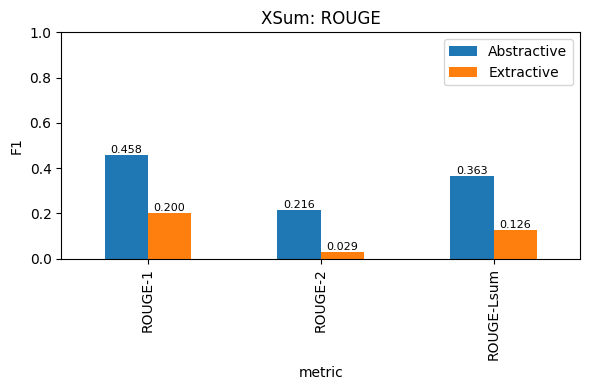

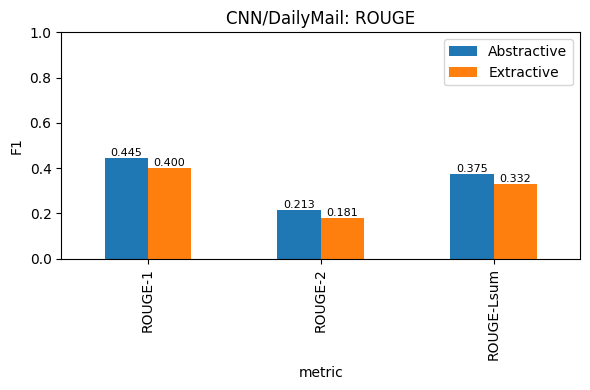

Saved charts to results/xsum_rouge_bar.png and results/cnn_rouge_bar.png


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

def plot_rouge(csv_path, title, out_path):
    df = pd.read_csv(csv_path)
    ax = df.set_index("metric").plot(kind="bar", figsize=(6,4))
    ax.set_title(title)
    ax.set_ylabel("F1")
    ax.set_ylim(0, 1.0)
    for p in ax.patches:
        ax.annotate(f"{p.get_height():.3f}", 
                    (p.get_x()+p.get_width()/2, p.get_height()),
                    ha='center', va='bottom', fontsize=8)
    plt.tight_layout()
    plt.savefig(out_path, dpi=200)
    plt.show()

plot_rouge("results/xsum_rouge.csv", "XSum: ROUGE", "results/xsum_rouge_bar.png")
plot_rouge("results/cnn_dailymail_rouge.csv", "CNN/DailyMail: ROUGE", "results/cnn_rouge_bar.png")
print("Saved charts to results/xsum_rouge_bar.png and results/cnn_rouge_bar.png")


In [ ]:
import pandas as pd

def head_examples(in_csv, out_csv, k=5):
    df = pd.read_csv(in_csv)
    cols = ["text","summary","abs_summary","ext_summary"] if "ext_summary" in df.columns else \
           ["text","summary","abs_summary","lead3_summary"]
    ex = df[cols].head(k)
    ex.to_csv(out_csv, index=False)
    return ex

print("XSum examples:")
display(head_examples("results/xsum_samples.csv", "results/xsum_examples_top5.csv", 5))

print("CNN/DailyMail examples:")
display(head_examples("results/cnn_dailymail_samples.csv", "results/cnn_examples_top5.csv", 5))

print("Saved: results/xsum_examples_top5.csv, results/cnn_examples_top5.csv")


XSum examples:


,text,summary,abs_summary,ext_summary
0,The sanctions freeze the US assets of those af...,The US government has imposed sanctions on 13 ...,The US has imposed sanctions on seven senior V...,The sanctions freeze the US assets of those af...
1,Sir Gareth attended a ceremony at Windsor Cast...,Wales rugby great Gareth Edwards has been knig...,Former Wales captain Gareth Edwards has been m...,Sir Gareth attended a ceremony at Windsor Cast...
2,Emmanuel Manzi from Italy won the event at Lla...,About 600 runners have taken part in the annua...,"More than 1,000 competitors have taken part in...",Emmanuel Manzi from Italy won the event at Lla...
3,"Rajab, who heads the Bahrain Centre for Human ...",Prominent Bahraini human rights activist Nabee...,Bahrain has freed prominent human rights activ...,"Rajab, who heads the Bahrain Centre for Human ..."
4,11 August 2015 Last updated at 19:18 BST\nSafi...,An 11-year-old migrant from Afghanistan has be...,"Safid, a five-year-old boy from Afghanistan, i...",11 August 2015 Last updated at 19:18 BST\nSafi...


CNN/DailyMail examples:


,text,summary,abs_summary,ext_summary
0,Down Augusta way they say the azaleas are in f...,Justin Rose bounced back from Florida misery b...,Justin Rose hit 17 out of 18 greens in regulat...,Down Augusta way they say the azaleas are in f...
1,There was no special treatment for Lewis Fergu...,Lewis Ferguson fell from Merrion Square at Win...,"Lewis Ferguson, 18, was mucking out the stable...",There was no special treatment for Lewis Fergu...
2,When emergency crews received a call saying 's...,"Woman reported 'someone' had been run over, bu...",Two ambulances were sent to Epping Forest afte...,When emergency crews received a call saying 's...
3,A loving boyfriend has granted his girlfriend ...,"Guo Kai and girlfriend Dong Hui, 22, had plann...","Dong Hui, 22, was diagnosed with bone cancer l...",A loving boyfriend has granted his girlfriend ...
4,(CNN)Sunday's announcement that Corinthian Col...,"David Wheeler: Corinthian, considered a ""preda...",Cynthia Schneider: Corinthian Colleges shuttin...,(CNN)Sunday's announcement that Corinthian Col...


Saved: results/xsum_examples_top5.csv, results/cnn_examples_top5.csv
